# Agentic flow to generate teaching modules following a learning design theorry



In [88]:
%run utilities.ipynb

# Youtube Search

In [89]:
from langchain_community.tools import YouTubeSearchTool
youtube_search = YouTubeSearchTool()
#youtube_search.run("historical roots of makerspaces and constructionist learning")

# Tavily Search

In [91]:

from tavily import TavilyClient
from langchain_community.tools.tavily_search import TavilySearchResults


client = OpenAI()
tavily_client = TavilyClient(api_key=tavily_api_key)
tavily_tool = TavilySearchResults(
    max_results=2,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # include_domains=[...],
    # exclude_domains=[...],
    # name="...",            # overwrite default tool name
    # description="...",     # overwrite default tool description
    # args_schema=...,       # overwrite default args_schema: BaseModel
)


# Structured Output Formats

In [4]:
class OutputFormat1(BaseModel):
    """
    Model representing a single module.
    """
    # Define required fields with descriptions
    description: str = Field(..., description="Short description of the module.")
    objectives: str = Field(..., description="Module Objectives.")

class Output1(BaseModel):
    """
    
    """
    # Define required fields with descriptions
    module: List[OutputFormat1] = Field(..., description="List of modules in the course")
    name: str = Field(..., description="Name of the course")

class OutputFormat2(BaseModel):
    """
    Model representing a single module.
    """
    assessments: str = Field(..., description="Assessments.")
    activities: str = Field(..., description="Hands-on activities")
    assignments:str = Field(..., description="Assignments")

class Output2(BaseModel):
    """
    
    """
    # Define required fields with descriptions
    module: List[OutputFormat2] = Field(..., description="List of modules in the course")
    name: str = Field(..., description="Name of the course")


class State(Dict):
    model: str
    course_name:str
    num_weeks:int
    out1:Output1
    out2:Output2
    reading_list:Annotated[list, operator.add]
    url_list:Annotated[list, operator.add]   


# Prompt templates

In [36]:
   
def get_prompt_template1(num_weeks, name):
    sys = f"""
    You are an expert in instructional design specializing in online course development.
    
    Your task is to:
    1. Design {num_weeks} well-structured learning modules for an online master's course.
    2. Use a backward design approach to create a comprehensive course map. The course map should include:
       - Module description 
       - Module objectives
    3. Ensure that the course structure aligns with the provided course information.
    4. Deliver the output as a fully formatted and validated document named "{name}" for immediate use.
    """

    user = f"""
    Course Title:{name}
    
    Course Description:
    This course provides an introduction to {name}, covering foundational concepts, theoretical principles, and practical applications.
    
    Extended Course Description:
    (Provide more details here)
    
    Learning Outcomes:
    1. Explain the most important concepts, such as superposition, measurmeent effect, entanglement and quantum bit (qubit).
    2. Understand how quantum algorithms are used to discover hidden patterns.
    3. Analyze and interpret Shor’s algorithm.
    """

    return sys, user

   


def get_prompt_template2(module):
    sys = f"""
    You are an instructional designer charged with creating activities,assessments and assignments for the provided learning module.
     """
    user=f"""
    Here is the module:
    {module}
    """
    return sys,user




def get_Search_Prompt(module):
    sys = f"""
    You are a researcher charged with providing information that can be used for 
    the user provided online learning module. Generate a list of search queries that will gather \
    any relevant information. Only generate 2 queries max.
     """
    user=f"""
    Here is the learning module description:
    {module.description}
     Here are the learning module ojectives:
    {module.objectives}
    """
    
    return sys,user
    

# Agents

output_agent1:
Generates module descriptions and learning objectives

output_agent2:
Generates activities,assessments and assignments for the provided learning module.

output_agent3:
Generates urls for reading and youtubes for each module




In [83]:
class Queries(BaseModel):
    queries: List[str]

   
def output_agent1(state)-> Output1:   
    model=state["model"]
    num=state["num_weeks"]
    name=state["course_name"]
    sys,user=get_prompt_template1(num,name)
    answer = client.beta.chat.completions.parse(
        model=model,
        messages=[ {"role": "system", "content": dedent(sys)},
                   {"role": "user","content": user } ],
                   response_format=Output1)
    answer= answer.choices[0].message.parsed
    state["out1"]=answer
    return state


def output_agent2(state)-> OutputFormat2:   
    model=state["model"]
    out1=state["out1"]
    state["out2"]=[]
    for module in out1.module:
        sys,user=get_prompt_template2(module)
        
        answer = client.beta.chat.completions.parse(
            model=model,
            messages=[ {"role": "system", "content": dedent(sys)},
                       {"role": "user","content": user } ],
                       response_format=OutputFormat2)
        answer= answer.choices[0].message.parsed
        state["out2"].append(answer)
    return state


def output_agent3(state):
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
    out1 = state["out1"]
    
    reading_list = []
    url_list = []

    for module in out1.module:
        sys, user = get_Search_Prompt(module)
        queries = model.with_structured_output(Queries).invoke([
            SystemMessage(content=sys),
            HumanMessage(content=user)
        ])
        
        module_reading_list = []
        module_url_list = []
        
        for q in queries.queries:
            print("\n q", q)
            
            response = tavily_client.search(query=q, max_results=1)
            
            query_readings = []
            for r in response['results']:
                query_readings.append(r['content'] + "\n" + r['url'])
            
            module_reading_list.extend(query_readings)  # Flatten the list
            query_urls = youtube_search.run(q, 2)
            module_url_list.extend(query_urls)  # Flatten the list
        
        rl = "\n\n".join(module_reading_list)  # Join as a single string
        reading_list.append(rl)
        
        url = "\n\n".join(module_url_list)  # Join URLs as a single string
        url_list.append(url)
        
    state["reading_list"] = reading_list
    state["url_list"] = url_list
    
    return{"reading_list": reading_list,"url_list":url_list}


# Final agent generates a Latex file from the outputs from the previous agents

In [84]:
class Formatting():
    
    def Latex_math(self):
        return f""" 
        - Use  
        \\documentclass{{article}}
        \\usepackage{{amsmath}}
        \\usepackage[a4paper, margin=0.5in]{{geometry}}  
        \\usepackage{{hyperref}}
        
        -If you use matrices use the following example as a guide:
                ***Example***:
               "\[
                \begin{{pmatrix}}
                1 & 2 & 3 \\
                4 & 5 & 6 \\
                7 & 8 & 9
                \end{{pmatrix}}
                \]"
        - Inline Math: Use $ ... $ for inline math.
                
        - Displayed Equations: Use \[ ... \] for displayed equations, which centers the math on its own line.
                
        - Sections and Items: Use \section*{{}} for unnumbered sections and enumerate or itemize for lists.

        - Always ensure that any opened brackets—such as `{{}}`, `[]`, or `()`—are properly closed in your expressions.

        -  Paragraph Formatting**: Break the text into paragraphs appropriately. 
            Use LaTeX commands to manage text justification to prevent overfull `\hbox` issues.
        -   If there is an url-link, then use \\url{{url-link}}
        """
        
 
        
    def Latex_Formatting(self,text):
        L_format=self.Latex_math()
        SYS_PROMPT = fr"""You are an expert in LaTeX document formatting. 
        Your task is to convert user-provided text, in any language, into a professionally structured LaTeX document. 
        
        ### Guidelines:
        - Preserve the entire content **exactly** as provided, ensuring no modifications, omissions, or reordering.
        - Adhere strictly to the specified formatting instructions to produce a clean, professional, and formally presentable document.
        - Maintain a **logical sectioning** and structured formatting to enhance readability and usability.
        """
  
    
     
        USER_PROMPT = fr"""Format the following content into a well-structured LaTeX document:
        
        **Content:**
        {text}
        
        ### **Formatting Requirements:**
        1. **Preserve all content** as-is—**no modifications, omissions, or rearrangements**.
        2. **Format each section individually**, ensuring clarity and proper LaTeX structure.
        3. **Maintain the original sequence** of content throughout the document.
        4. **Strictly apply the following LaTeX formatting guidelines:** {L_format}.
        5. Ensure the document is **professionally formatted, well-organized, and ready for formal presentation**.
        
        Return only the final LaTeX code without additional explanations."""


        model= ChatOpenAI(model="gpt-4o", temperature=0) 
        messages = [
            SystemMessage(content=SYS_PROMPT), 
            HumanMessage(content=USER_PROMPT)  
        ]
        response = model.invoke(messages).content
        return response

class Final_Processing():
    def __init__(self,text):
        self.format=Formatting()
        self.text=text

    def Latex(self):
        Latex=self.format.Latex_Formatting(self.text) 
        self.Save_File(Latex,"EN_Latex")
    
    def translate(self,language):  
        output=translator.translate_text(self.text, target_lang="DE").text  
        Latex=self.format.Latex_Formatting(output) 
        self.Save_File(Latex,output,"DE_Latex")
        return output
    
    def Save_File(self,inp,name:str): 
        file_path = fr".\outputfiles\{name}.tex"
        if not os.path.exists( file_path):
           os.makedirs(folder_path)

        with open(file_path, "w",encoding="utf-8") as file:
            file.write(inp)        

def final_agent(state):  

    structured_data = []
    for module1, module2, reading, url in zip(state["out1"].module, state["out2"], state["reading_list"], state["url_list"]):
        structured_data.append({
            "Module": module1.model_dump() | module2.model_dump(),
            "Reading": reading,
            "URL": url
        })
    
    # Convert to JSON for further processing
    json_data = json.dumps(structured_data, indent=4)

    FP=Final_Processing(json_data)
    FP.Latex()
    return state

# Langgraph 

https://langchain-ai.github.io/langgraph/how-tos/branching/#how-to-run-graph-nodes-in-parallel

graph initialized


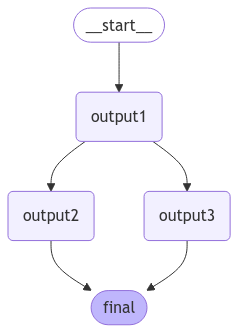

In [85]:
def init_graph():
    memory = MemorySaver()
    graph_builder = StateGraph(State)    
    graph_builder.add_node("output1",output_agent1)
    graph_builder.add_node("output2",output_agent2)
    graph_builder.add_node("output3",output_agent3)
    graph_builder.add_node("final",final_agent)
    
    graph_builder.set_entry_point("output1")
    graph_builder.add_edge("output1","output2")
    graph_builder.add_edge("output1","output3")
    graph_builder.add_edge("output2","final")
    graph_builder.add_edge("output3","final")

    graph = graph_builder.compile(checkpointer=memory)
    print("graph initialized")
    return graph

def run_graph(state,graph):       
        thread = {"configurable": {"thread_id": "1"}}
        state = graph.invoke(state,thread)
        return state
graph=init_graph()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass            

In [86]:
model1 ="o1-mini" 
model2 ="gpt-4o" 
model3 ="gpt-4o-mini"
state=State()
state["course_name"]="Quantum Computing"
state["num_weeks"]=4
state["model"]=model3

state=run_graph(state,graph)


 q introduction to quantum computing concepts qubits superposition entanglement
['https://www.youtube.com/watch?v=fkAAbXPEAtU&pp=ygVMaW50cm9kdWN0aW9uIHRvIHF1YW50dW0gY29tcHV0aW5nIGNvbmNlcHRzIHF1Yml0cyBzdXBlcnBvc2l0aW9uIGVudGFuZ2xlbWVudA%3D%3D', 'https://www.youtube.com/watch?v=g_IaVepNDT4&pp=ygVMaW50cm9kdWN0aW9uIHRvIHF1YW50dW0gY29tcHV0aW5nIGNvbmNlcHRzIHF1Yml0cyBzdXBlcnBvc2l0aW9uIGVudGFuZ2xlbWVudA%3D%3D']
 q importance of qubits superposition entanglement in quantum computing
['https://www.youtube.com/watch?v=90za6mazNps&pp=ygVEaW1wb3J0YW5jZSBvZiBxdWJpdHMgc3VwZXJwb3NpdGlvbiBlbnRhbmdsZW1lbnQgaW4gcXVhbnR1bSBjb21wdXRpbmc%3D', 'https://www.youtube.com/watch?v=g_IaVepNDT4&pp=ygVEaW1wb3J0YW5jZSBvZiBxdWJpdHMgc3VwZXJwb3NpdGlvbiBlbnRhbmdsZW1lbnQgaW4gcXVhbnR1bSBjb21wdXRpbmc%3D']
 q differences between quantum algorithms and classical algorithms
['https://www.youtube.com/watch?v=-ysVGWtAjio&t=91s&pp=ygU_ZGlmZmVyZW5jZXMgYmV0d2VlbiBxdWFudHVtIGFsZ29yaXRobXMgYW5kIGNsYXNzaWNhbCBhbGdvcml0aG1z', 'https:/